![alt text](http://drive.google.com/uc?export=view&id=1IFEWet-Aw4DhkkVe1xv_2YYqlvRe9m5_)

# 9.1 GAMLSS  with Continuous Distributions {.unnumbered}

This tutorial will guide you through building GAMLSS-style models from scratch using torch.distributions, allowing you to model all parameters of a distribution (mean, scale, shape) as flexible functions of covariates — with custom link functions, proper initialization, and uncertainty quantification. Thsi 

We’ll use real-world education data and fit models with:

-  Normal (Gaussian regression)
-  Student-t (robust regression)
-  Gamma (positive, skewed response)
-  Beta (bounded response)


At the end,  we will enhance all GAMLSS models with:

- Smoothing Splines — for flexible nonlinear modeling of continuous predictors (e.g., Interest)
- Random Effects — for group-specific adjustments (e.g., by Country)

###  Install and Load  Required Python Packages

We use PyTorch in statistical analysis — even for classical models like GAMLSS — because it provides a powerful, flexible, and modern computational foundation that goes beyond traditional tools. Its automatic differentiation engine eliminates the need for manual gradient derivations, enabling easy optimization of complex likelihoods with custom link functions and distributions. Built-in GPU acceleration speeds up computation, while its modular design allows seamless integration of linear predictors, smoothing splines, random effects, and even neural networks within the same framework. PyTorch’s `torch.distributions` module simplifies uncertainty quantification through sampling and probability evaluation, and its interoperability with the Python data science stack (NumPy, Pandas, Scikit-learn) ensures smooth workflows. Ultimately, PyTorch empowers statisticians and data scientists to build, fit, and visualize rich probabilistic models with unprecedented flexibility and efficiency — turning theoretical models into scalable, real-world solutions.

In [ ]:
%pip install torch

In [14]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal, StudentT, Gamma, Beta

# For splines
from sklearn.preprocessing import SplineTransformer

# Set seeds
torch.manual_seed(101)
np.random.seed(101)

# Plot styling
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print(" Libraries loaded.")

 Libraries loaded.


### Data 

In this exercise, we utilize a [dataset](https://raw.githubusercontent.com/m-clark/generalized-additive-models/master/data/pisasci2006.csv) that includes average science scores by country from the Programme for International Student Assessment ([PISA](https://www.oecd.org/en/about/programmes/pisa.html)) conducted in 2006. Alongside these scores, we also consider [data](https://hdr.undp.org/data-center) from the United Nations, which includes Gross National Income (GNI) per capita (adjusted for Purchasing Power Parity in 2005 dollars), the Educational Index, the Health Index, and the Human Development Index (HDI).

The education component is measured by the mean years of schooling for adults aged 25 years and older and the expected years of schooling for children of school entry Income. The health index is determined by life expectancy at birth, while the wealth component is based on GNI per capita. The HDI establishes minimum and maximum values for each dimension, with the resulting scores indicating each country's position relative to these endpoints, expressed as a value between 0 and 1.

The key variables are as follows (variable abbreviations in bold):

-   **Overall** Science Score (average score for 15 year olds)

-   **Interest** in science

-   Identifying scientific **Issues**

-   **Explaining** phenomena scientifically

-   **Support** for scientific inquiry

-   **Income** Index

-   **Health** Index

-   **Edu**cation Index

-   **H**uman **D**evelopment **I**ndex (composed of the Income index, Health Index, and Education Index)

In [49]:
# Set random seeds for reproducibility
torch.manual_seed(101)
np.random.seed(101)

# Load data
url = 'https://raw.githubusercontent.com/m-clark/generalized-additive-models/master/data/pisasci2006.csv'
mf = pd.read_csv(url)

# Define Western Europe countries
western_europe = [
    'Austria', 'Belgium', 'Czech Republic', 'Denmark', 'Estonia',
    'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland',
    'Ireland', 'Italy', 'Luxembourg', 'Netherlands', 'Norway',
    'Poland', 'Portugal', 'Slovak Republic', 'Slovenia', 'Spain',
    'Sweden', 'Switzerland'
]

# Create clean DataFrame
df = mf[['Country', 'Overall', 'Edu', 'Income', 'Health', 'HDI', 'Interest']].copy()
df['region_broad'] = df['Country'].apply(lambda x: 'Western Europe' if x in western_europe else 'Other Regions')
df['region_broad'] = pd.Categorical(df['region_broad'], categories=['Western Europe', 'Other Regions'])
df = df.dropna(subset=['Overall', 'Edu', 'Income', 'Health', 'HDI', 'Interest'])

# Stratified train-test split
train, test = train_test_split(df, test_size=0.2, stratify=df['region_broad'], random_state=101)

# Prepare features and target
X_train = train[['Edu', 'Health', 'HDI', 'Interest', 'region_broad']].copy()
y_train = train['Overall'].values.astype(np.float32)

X_test = test[['Edu', 'Health', 'HDI', 'Interest', 'region_broad']].copy()
y_test = test['Overall'].values.astype(np.float32)

# One-hot encode categorical variable
X_train_encoded = pd.get_dummies(X_train, columns=['region_broad'], drop_first=True).astype(np.float32).values
X_test_encoded = pd.get_dummies(X_test, columns=['region_broad'], drop_first=True).astype(np.float32).values

# Create prediction grid for visualization
X_new = pd.DataFrame({
    'Edu': np.full(100, np.mean(train['Edu'])),
    'Health': np.full(100, np.mean(train['Health'])),
    'HDI': np.full(100, np.mean(train['HDI'])),
    'Interest': np.linspace(train['Interest'].min(), train['Interest'].max(), 100),
    'region_broad_Western Europe': np.ones(100, dtype=np.float32)
})
X_new_encoded = X_new.values.astype(np.float32)

# Convert to tensors
X_train_t = torch.tensor(X_train_encoded, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_t = torch.tensor(X_test_encoded, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
X_new_t = torch.tensor(X_new_encoded, dtype=torch.float32)

# Optional: Standardize features for better training stability
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)
X_new_scaled = scaler.transform(X_new_encoded)

X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
X_new_t = torch.tensor(X_new_scaled, dtype=torch.float32)

print("Data prepared and standardized.")


Data prepared and standardized.


## Define GAMLSS-like Models in PyTorch

We’ll define 4 models. Each models distribution parameters with appropriate link functions and stable initialization.



### Model 1: Normal Distribution (Classic Regression)

In [27]:
class NormalModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.loc_layer = nn.Linear(input_dim, 1)
        self.log_scale_layer = nn.Linear(input_dim, 1)

        # Initialize for stability
        nn.init.zeros_(self.log_scale_layer.weight)
        nn.init.constant_(self.log_scale_layer.bias, 0.0)  # scale ≈ 1.0

    def forward(self, x):
        loc = self.loc_layer(x)
        scale = torch.exp(self.log_scale_layer(x))  # Always positive
        return Normal(loc=loc, scale=scale)

    def predict_with_uncertainty(self, x, n_samples=1000):
        self.eval()
        with torch.no_grad():
            dist = self.forward(x)
            samples = dist.sample((n_samples,))
            mean_pred = samples.mean(dim=0).squeeze().numpy()
            std_pred = samples.std(dim=0).squeeze().numpy()
        return mean_pred, std_pred

### Model 2: Student-t Distribution (Robust to Outliers)

In [28]:
class StudentTModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.loc_layer = nn.Linear(input_dim, 1)
        self.log_scale_layer = nn.Linear(input_dim, 1)
        self.log_df_layer = nn.Linear(input_dim, 1)

        # Initialize for stability
        nn.init.zeros_(self.log_scale_layer.weight)
        nn.init.constant_(self.log_scale_layer.bias, 0.0)  # scale ≈ 1.0

        nn.init.zeros_(self.log_df_layer.weight)
        nn.init.constant_(self.log_df_layer.bias, 1.0)    # df ≈ exp(1) + 2 ≈ 4.7

    def forward(self, x):
        loc = self.loc_layer(x)
        scale = torch.exp(self.log_scale_layer(x))
        df = torch.exp(self.log_df_layer(x)) + 2.0  # Ensure >2 for finite variance
        return StudentT(df=df, loc=loc, scale=scale)

    def predict_with_uncertainty(self, x, n_samples=1000):
        self.eval()
        with torch.no_grad():
            dist = self.forward(x)
            samples = dist.sample((n_samples,))
            mean_pred = samples.mean(dim=0).squeeze().numpy()
            std_pred = samples.std(dim=0).squeeze().numpy()
        return mean_pred, std_pred

 ### Model 3: Gamma Distribution (Positive, Skewed Response)

In [29]:
class GammaModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.log_mu_layer = nn.Linear(input_dim, 1)
        self.log_sigma_layer = nn.Linear(input_dim, 1)

        # Initialize to predict mu ≈ median(y), sigma ≈ std(y)
        y_med = torch.median(y_train_t).item()
        y_std = y_train_t.std().item()

        nn.init.zeros_(self.log_mu_layer.weight)
        nn.init.constant_(self.log_mu_layer.bias, np.log(y_med + 1e-6))

        nn.init.zeros_(self.log_sigma_layer.weight)
        nn.init.constant_(self.log_sigma_layer.bias, np.log(y_std + 1e-6))

    def forward(self, x):
        mu = torch.exp(self.log_mu_layer(x))             # Log link → mu > 0
        sigma = torch.exp(self.log_sigma_layer(x))       # Log link → sigma > 0

        # Convert to Gamma(concentration, rate)
        concentration = (mu ** 2) / (sigma ** 2)
        rate = mu / (sigma ** 2)

        return Gamma(concentration=concentration, rate=rate)

    def predict_with_uncertainty(self, x, n_samples=1000):
        self.eval()
        with torch.no_grad():
            dist = self.forward(x)
            samples = dist.sample((n_samples,))
            mean_pred = samples.mean(dim=0).squeeze().numpy()
            std_pred = samples.std(dim=0).squeeze().numpy()
        return mean_pred, std_pred

### Model 4: Beta Distribution (Bounded Response [0,1])

In [30]:
class BetaModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.logit_mu_layer = nn.Linear(input_dim, 1)
        self.log_kappa_layer = nn.Linear(input_dim, 1)

        # Initialize mu to 0.5, kappa to 10 (moderate precision)
        nn.init.zeros_(self.logit_mu_layer.weight)
        nn.init.constant_(self.logit_mu_layer.bias, 0.0)  # sigmoid(0) = 0.5

        nn.init.zeros_(self.log_kappa_layer.weight)
        nn.init.constant_(self.log_kappa_layer.bias, np.log(10.0))

    def forward(self, x):
        mu = torch.sigmoid(self.logit_mu_layer(x))       # Logit link → mu ∈ (0,1)
        kappa = torch.exp(self.log_kappa_layer(x))       # Log link → kappa > 0

        alpha = mu * kappa
        beta = (1 - mu) * kappa

        return Beta(concentration1=alpha, concentration0=beta)

    def predict_with_uncertainty(self, x, n_samples=1000, y_min=None, y_max=None):
        self.eval()
        with torch.no_grad():
            dist = self.forward(x)
            samples_scaled = dist.sample((n_samples,))
            if y_min is not None and y_max is not None:
                # Back-transform to original scale
                samples_original = samples_scaled * (y_max - y_min) + y_min
                mean_pred = samples_original.mean(dim=0).squeeze().numpy()
                std_pred = samples_original.std(dim=0).squeeze().numpy()
            else:
                mean_pred = samples_scaled.mean(dim=0).squeeze().numpy()
                std_pred = samples_scaled.std(dim=0).squeeze().numpy()
        return mean_pred, std_pred

### Train all Models

In [32]:
def train_model(model, X_train, y_train, num_epochs=1000, lr=0.01, verbose=True):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()
    
    losses = []
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        dist = model(X_train)
        loss = -dist.log_prob(y_train).mean()  # Negative log-likelihood
        
        # Optional: Gradient clipping for extra stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        if verbose and epoch % 200 == 0:
            print(f"Epoch {epoch:4d}, Loss: {loss.item():.4f}")
    
    return losses

# Store predictions
predictions = {}

# ----------------------------
# Train Normal Model
# ----------------------------
print("\n" + "="*50)
print("TRAINING NORMAL MODEL")
print("="*50)
model_normal = NormalModel(X_train_t.shape[1])
losses_normal = train_model(model_normal, X_train_t, y_train_t)
mu_normal, std_normal = model_normal.predict_with_uncertainty(X_new_t)
predictions['Normal'] = (mu_normal, std_normal)

# ----------------------------
# Train Student-t Model
# ----------------------------
print("\n" + "="*50)
print("TRAINING STUDENT-T MODEL")
print("="*50)
model_student = StudentTModel(X_train_t.shape[1])
losses_student = train_model(model_student, X_train_t, y_train_t)
mu_student, std_student = model_student.predict_with_uncertainty(X_new_t)
predictions['StudentT'] = (mu_student, std_student)

# ----------------------------
# Train Gamma Model
# ----------------------------
print("\n" + "="*50)
print("TRAINING GAMMA MODEL")
print("="*50)
model_gamma = GammaModel(X_train_t.shape[1])
losses_gamma = train_model(model_gamma, X_train_t, y_train_t)
mu_gamma, std_gamma = model_gamma.predict_with_uncertainty(X_new_t)
predictions['Gamma'] = (mu_gamma, std_gamma)

# ----------------------------
# Train Beta Model (requires scaled y)
# ----------------------------
print("\n" + "="*50)
print("TRAINING BETA MODEL")
print("="*50)

# Scale y to [0,1]
y_min, y_max = y_train.min(), y_train.max()
y_train_scaled = (y_train - y_min) / (y_max - y_min)
y_train_scaled_t = torch.tensor(y_train_scaled, dtype=torch.float32).unsqueeze(1).clamp(1e-4, 1 - 1e-4)

model_beta = BetaModel(X_train_t.shape[1])
losses_beta = train_model(model_beta, X_train_t, y_train_scaled_t)
mu_beta, std_beta = model_beta.predict_with_uncertainty(X_new_t, y_min=y_min, y_max=y_max)
predictions['Beta'] = (mu_beta, std_beta)

print("\n All models trained successfully!")


TRAINING NORMAL MODEL
Epoch    0, Loss: 111046.2188
Epoch  200, Loss: 11607.7852
Epoch  400, Loss: 4701.0234
Epoch  600, Loss: 2625.6274
Epoch  800, Loss: 1698.8428

TRAINING STUDENT-T MODEL
Epoch    0, Loss: 31.6516
Epoch  200, Loss: 16.6888
Epoch  400, Loss: 12.3936
Epoch  600, Loss: 9.6513
Epoch  800, Loss: 7.7656

TRAINING GAMMA MODEL
Epoch    0, Loss: 5.5375
Epoch  200, Loss: 4.6237
Epoch  400, Loss: 4.6233
Epoch  600, Loss: 4.6234
Epoch  800, Loss: 4.6232

TRAINING BETA MODEL
Epoch    0, Loss: 1.6606
Epoch  200, Loss: -0.8303
Epoch  400, Loss: -0.9071
Epoch  600, Loss: -0.9390
Epoch  800, Loss: -0.9608

 All models trained successfully!


### Visualize Predictions

Plot predicted mean and ±1 SD uncertainty across Interest levels.

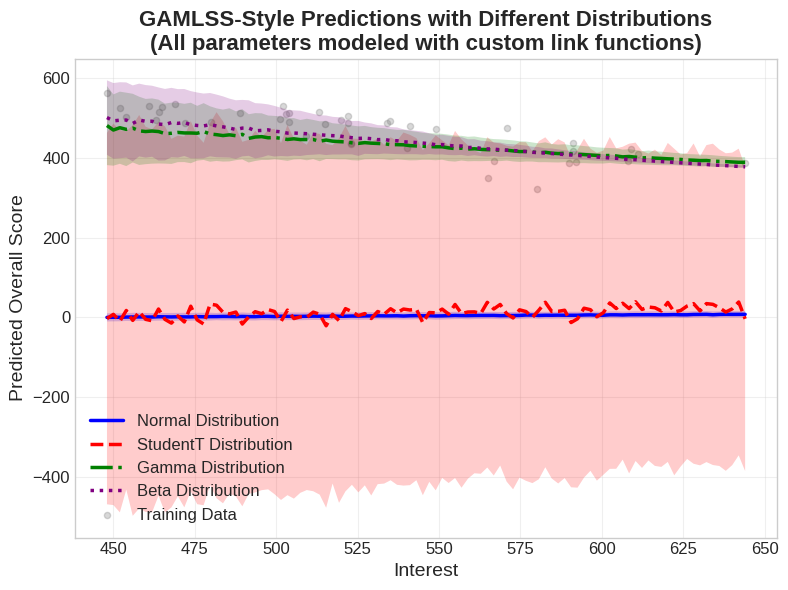

In [34]:
plt.figure(figsize=(8, 6))

interest_vals = X_new['Interest'].values

# Plot each model
colors = ['blue', 'red', 'green', 'purple']
linestyles = ['-', '--', '-.', ':']
models = ['Normal', 'StudentT', 'Gamma', 'Beta']

for i, model_name in enumerate(models):
    mu, std = predictions[model_name]
    plt.plot(interest_vals, mu, 
             label=f'{model_name} Distribution', 
             color=colors[i], 
             linestyle=linestyles[i], 
             linewidth=2.5)
    plt.fill_between(interest_vals, mu - std, mu + std, 
                     color=colors[i], alpha=0.2, edgecolor='none')

# Customize plot
plt.xlabel('Interest', fontsize=14)
plt.ylabel('Predicted Overall Score', fontsize=14)
plt.title('GAMLSS-Style Predictions with Different Distributions\n(All parameters modeled with custom link functions)', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='upper left')
plt.grid(True, alpha=0.3)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add data scatter for context
plt.scatter(train['Interest'], train['Overall'], 
           alpha=0.3, color='gray', s=20, label='Training Data', zorder=0)

plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

### Plot Training Losses

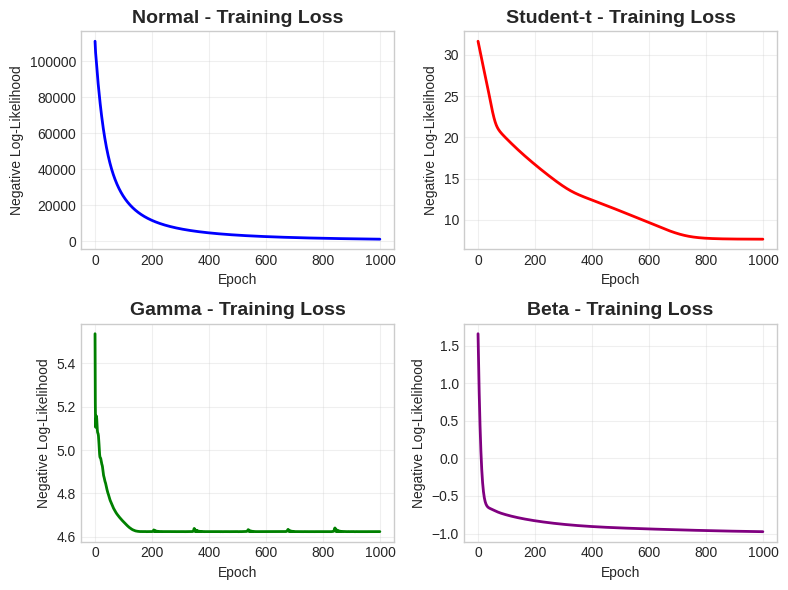

In [35]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.flatten()

losses = [losses_normal, losses_student, losses_gamma, losses_beta]
titles = ['Normal', 'Student-t', 'Gamma', 'Beta']

for i, (loss, title) in enumerate(zip(losses, titles)):
    axes[i].plot(loss, color=colors[i], linewidth=2)
    axes[i].set_title(f'{title} - Training Loss', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Negative Log-Likelihood')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

###  Evaluate Models on Test Set

In [37]:
def evaluate_log_likelihood(model, X_test, y_test, is_beta=False, y_min=None, y_max=None):
    model.eval()
    with torch.no_grad():
        if is_beta:
            # Scale y for Beta model
            y_test_scaled = (y_test.squeeze() - y_min) / (y_max - y_min)
            y_test_scaled = y_test_scaled.clamp(1e-4, 1 - 1e-4).unsqueeze(1)
            dist = model(X_test)
            log_likelihood = dist.log_prob(y_test_scaled).mean().item()
        else:
            dist = model(X_test)
            log_likelihood = dist.log_prob(y_test).mean().item()
    return log_likelihood

print("\nMODEL COMPARISON — Test Set Log-Likelihood (Higher is Better)\n")
print("="*70)

ll_normal = evaluate_log_likelihood(model_normal, X_test_t, y_test_t)
print(f"Normal      : {ll_normal:.4f}")

ll_student = evaluate_log_likelihood(model_student, X_test_t, y_test_t)
print(f"Student-t   : {ll_student:.4f}")

ll_gamma = evaluate_log_likelihood(model_gamma, X_test_t, y_test_t)
print(f"Gamma       : {ll_gamma:.4f}")

ll_beta = evaluate_log_likelihood(model_beta, X_test_t, y_test_t, 
                                  is_beta=True, y_min=y_min, y_max=y_max)
print(f"Beta        : {ll_beta:.4f}")

print("="*70)
best_model = max([('Normal', ll_normal), 
                  ('Student-t', ll_student), 
                  ('Gamma', ll_gamma), 
                  ('Beta', ll_beta)], key=lambda x: x[1])
print(f"\nBest Model: {best_model[0]} (Log-Likelihood: {best_model[1]:.4f})")


MODEL COMPARISON — Test Set Log-Likelihood (Higher is Better)

Normal      : -1296.3783
Student-t   : -7.7099
Gamma       : -6.0597
Beta        : -2.0577

Best Model: Beta (Log-Likelihood: -2.0577)


## GAMLSS with Splines & Random Effects

###  Load Data & Prepare with Country IDs for Random Effects

In [50]:
# Load data
url = 'https://raw.githubusercontent.com/m-clark/generalized-additive-models/master/data/pisasci2006.csv'
mf = pd.read_csv(url)

# Define Western Europe countries
western_europe = [
    'Austria', 'Belgium', 'Czech Republic', 'Denmark', 'Estonia',
    'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland',
    'Ireland', 'Italy', 'Luxembourg', 'Netherlands', 'Norway',
    'Poland', 'Portugal', 'Slovak Republic', 'Slovenia', 'Spain',
    'Sweden', 'Switzerland'
]

# Create clean DataFrame
df = mf[['Country', 'Overall', 'Edu', 'Income', 'Health', 'HDI', 'Interest']].copy()
df['region_broad'] = df['Country'].apply(lambda x: 'Western Europe' if x in western_europe else 'Other Regions')
df['region_broad'] = pd.Categorical(df['region_broad'], categories=['Western Europe', 'Other Regions'])
df = df.dropna(subset=['Overall', 'Edu', 'Income', 'Health', 'HDI', 'Interest'])

# Encode Country for random effects
country_encoder = LabelEncoder()
df['country_id'] = country_encoder.fit_transform(df['Country'])
n_countries = len(country_encoder.classes_)

# Stratified train-test split (by region_broad)
train, test = train_test_split(df, test_size=0.2, stratify=df['region_broad'], random_state=101)

# Prepare features (excluding Country, but keeping country_id for RE)
feature_cols = ['Edu', 'Health', 'HDI', 'Interest', 'region_broad']
X_train = train[feature_cols].copy()
y_train = train['Overall'].values.astype(np.float32)
country_id_train = torch.tensor(train['country_id'].values, dtype=torch.long)

X_test = test[feature_cols].copy()
y_test = test['Overall'].values.astype(np.float32)
country_id_test = torch.tensor(test['country_id'].values, dtype=torch.long)

# One-hot encode categorical variable
X_train_encoded = pd.get_dummies(X_train, columns=['region_broad'], drop_first=True).astype(np.float32).values
X_test_encoded = pd.get_dummies(X_test, columns=['region_broad'], drop_first=True).astype(np.float32).values

# Create prediction grid (for Interest spline visualization)
interest_grid = np.linspace(train['Interest'].min(), train['Interest'].max(), 100)
X_new = pd.DataFrame({
    'Edu': np.full(100, np.mean(train['Edu'])),
    'Health': np.full(100, np.mean(train['Health'])),
    'HDI': np.full(100, np.mean(train['HDI'])),
    'Interest': interest_grid,
    'region_broad_Western Europe': np.ones(100, dtype=np.float32)
})
X_new_encoded = X_new.values.astype(np.float32)

# Standardize features (except country_id)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)
X_new_scaled = scaler.transform(X_new_encoded)

# Convert to tensors
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
X_new_t = torch.tensor(X_new_scaled, dtype=torch.float32)
country_id_train_t = country_id_train
country_id_test_t = torch.tensor(test['country_id'].values, dtype=torch.long)
country_id_new_t = torch.zeros(100, dtype=torch.long)  # dummy for prediction

print("Data prepared with country IDs for random effects.")
print(f"Train shape: {X_train_t.shape}, Countries: {n_countries}")

Data prepared with country IDs for random effects.
Train shape: torch.Size([41, 5]), Countries: 52


### Build B-Spline Basis for Nonlinear 


We’ll create a spline basis for the Interest variable (column index 3).




In [51]:
from sklearn.preprocessing import SplineTransformer

def create_spline_bases(X, feature_idx, n_knots=10, degree=3):
    """
    Create B-spline basis for one feature in X.
    Returns: original X with spline-expanded feature replacing original
    """
    spline = SplineTransformer(n_knots=n_knots, degree=degree, include_bias=False)
    # Extract and expand the feature
    feature_to_expand = X[:, [feature_idx]]  # Keep 2D
    spline_basis = spline.fit_transform(feature_to_expand)
    
    # Replace original feature with spline basis
    X_new = np.concatenate([
        X[:, :feature_idx],
        spline_basis,
        X[:, feature_idx+1:]
    ], axis=1)
    
    return X_new, spline

# Apply to Interest (index 3 in X_train_encoded)
X_train_spline, spline_transformer = create_spline_bases(X_train_scaled, feature_idx=3, n_knots=8, degree=3)
X_test_spline = create_spline_bases(X_test_scaled, feature_idx=3, n_knots=8, degree=3)[0]  # Use fitted transformer
X_new_spline = create_spline_bases(X_new_scaled, feature_idx=3, n_knots=8, degree=3)[0]

# Convert to tensors
X_train_spline_t = torch.tensor(X_train_spline, dtype=torch.float32)
X_test_spline_t = torch.tensor(X_test_spline, dtype=torch.float32)
X_new_spline_t = torch.tensor(X_new_spline, dtype=torch.float32)

print(f" Spline basis created. Original dim: {X_train_scaled.shape[1]}, New dim: {X_train_spline_t.shape[1]}")

 Spline basis created. Original dim: 5, New dim: 13


### Define Enhanced Models with Splines & Random Effects

Each model now includes:

* Linear effects for `Edu`, `Health`, `HDI`, `region_broad

* Spline basis for `Interest` (already embedded in `X_*_spline_t`)

* Random intercept per country

#### Enhanced Normal Model

In [40]:
class NormalModelEnhanced(nn.Module):
    def __init__(self, input_dim, n_countries):
        super().__init__()
        self.loc_linear = nn.Linear(input_dim, 1)
        self.log_scale_linear = nn.Linear(input_dim, 1)
        self.country_re = nn.Embedding(n_countries, 1)
        
        # Initialize for stability
        nn.init.zeros_(self.log_scale_linear.weight)
        nn.init.constant_(self.log_scale_linear.bias, 0.0)
        nn.init.zeros_(self.country_re.weight)  # Start with zero random effects

    def forward(self, x, country_id):
        loc = self.loc_linear(x) + self.country_re(country_id)
        scale = torch.exp(self.log_scale_linear(x))
        return Normal(loc=loc, scale=scale)

    def predict_with_uncertainty(self, x, country_id=None, n_samples=1000):
        if country_id is None:
            country_id = torch.zeros(x.shape[0], dtype=torch.long)
        self.eval()
        with torch.no_grad():
            dist = self.forward(x, country_id)
            samples = dist.sample((n_samples,))
            mean_pred = samples.mean(dim=0).squeeze().numpy()
            std_pred = samples.std(dim=0).squeeze().numpy()
        return mean_pred, std_pred

#### Enhanced Student-t Model

In [41]:
class StudentTModelEnhanced(nn.Module):
    def __init__(self, input_dim, n_countries):
        super().__init__()
        self.loc_linear = nn.Linear(input_dim, 1)
        self.log_scale_linear = nn.Linear(input_dim, 1)
        self.log_df_linear = nn.Linear(input_dim, 1)
        self.country_re = nn.Embedding(n_countries, 1)
        
        # Initialize for stability
        nn.init.zeros_(self.log_scale_linear.weight)
        nn.init.constant_(self.log_scale_linear.bias, 0.0)
        nn.init.zeros_(self.log_df_linear.weight)
        nn.init.constant_(self.log_df_linear.bias, 1.0)
        nn.init.zeros_(self.country_re.weight)

    def forward(self, x, country_id):
        loc = self.loc_linear(x) + self.country_re(country_id)
        scale = torch.exp(self.log_scale_linear(x))
        df = torch.exp(self.log_df_linear(x)) + 2.0
        return StudentT(df=df, loc=loc, scale=scale)

    def predict_with_uncertainty(self, x, country_id=None, n_samples=1000):
        if country_id is None:
            country_id = torch.zeros(x.shape[0], dtype=torch.long)
        self.eval()
        with torch.no_grad():
            dist = self.forward(x, country_id)
            samples = dist.sample((n_samples,))
            mean_pred = samples.mean(dim=0).squeeze().numpy()
            std_pred = samples.std(dim=0).squeeze().numpy()
        return mean_pred, std_pred

#### Enhanced Gamma Model

In [42]:
class GammaModelEnhanced(nn.Module):
    def __init__(self, input_dim, n_countries):
        super().__init__()
        self.log_mu_linear = nn.Linear(input_dim, 1)
        self.log_sigma_linear = nn.Linear(input_dim, 1)
        self.country_re = nn.Embedding(n_countries, 1)
        
        # Initialize to predict mu ≈ median(y), sigma ≈ std(y)
        y_med = 500.0  # Approximate median of PISA scores
        y_std = 50.0   # Approximate std
        
        nn.init.zeros_(self.log_mu_linear.weight)
        nn.init.constant_(self.log_mu_linear.bias, np.log(y_med + 1e-6))
        nn.init.zeros_(self.log_sigma_linear.weight)
        nn.init.constant_(self.log_sigma_linear.bias, np.log(y_std + 1e-6))
        nn.init.zeros_(self.country_re.weight)

    def forward(self, x, country_id):
        log_mu = self.log_mu_linear(x) + self.country_re(country_id)
        mu = torch.exp(log_mu)
        sigma = torch.exp(self.log_sigma_linear(x))
        
        concentration = (mu ** 2) / (sigma ** 2)
        rate = mu / (sigma ** 2)
        return Gamma(concentration=concentration, rate=rate)

    def predict_with_uncertainty(self, x, country_id=None, n_samples=1000):
        if country_id is None:
            country_id = torch.zeros(x.shape[0], dtype=torch.long)
        self.eval()
        with torch.no_grad():
            dist = self.forward(x, country_id)
            samples = dist.sample((n_samples,))
            mean_pred = samples.mean(dim=0).squeeze().numpy()
            std_pred = samples.std(dim=0).squeeze().numpy()
        return mean_pred, std_pred

#### Enhanced Beta Model

In [43]:
class BetaModelEnhanced(nn.Module):
    def __init__(self, input_dim, n_countries):
        super().__init__()
        self.logit_mu_linear = nn.Linear(input_dim, 1)
        self.log_kappa_linear = nn.Linear(input_dim, 1)
        self.country_re = nn.Embedding(n_countries, 1)
        
        # Initialize mu to 0.5, kappa to 10
        nn.init.zeros_(self.logit_mu_linear.weight)
        nn.init.constant_(self.logit_mu_linear.bias, 0.0)
        nn.init.zeros_(self.log_kappa_linear.weight)
        nn.init.constant_(self.log_kappa_linear.bias, np.log(10.0))
        nn.init.zeros_(self.country_re.weight)

    def forward(self, x, country_id):
        logit_mu = self.logit_mu_linear(x) + self.country_re(country_id)
        mu = torch.sigmoid(logit_mu)
        kappa = torch.exp(self.log_kappa_linear(x))
        
        alpha = mu * kappa
        beta = (1 - mu) * kappa
        return Beta(concentration1=alpha, concentration0=beta)

    def predict_with_uncertainty(self, x, country_id=None, n_samples=1000, y_min=None, y_max=None):
        if country_id is None:
            country_id = torch.zeros(x.shape[0], dtype=torch.long)
        self.eval()
        with torch.no_grad():
            dist = self.forward(x, country_id)
            samples_scaled = dist.sample((n_samples,))
            if y_min is not None and y_max is not None:
                samples_original = samples_scaled * (y_max - y_min) + y_min
                mean_pred = samples_original.mean(dim=0).squeeze().numpy()
                std_pred = samples_original.std(dim=0).squeeze().numpy()
            else:
                mean_pred = samples_scaled.mean(dim=0).squeeze().numpy()
                std_pred = samples_scaled.std(dim=0).squeeze().numpy()
        return mean_pred, std_pred

### Train All Enhanced Models

In [45]:
def train_model_enhanced(model, X_train, country_id, y_train, num_epochs=1500, lr=0.01, verbose=True):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()
    
    losses = []
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        dist = model(X_train, country_id)
        loss = -dist.log_prob(y_train).mean()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        if verbose and epoch % 300 == 0:
            print(f"Epoch {epoch:4d}, Loss: {loss.item():.4f}")
    
    return losses

# Scale y for Beta model
y_min, y_max = y_train.min(), y_train.max()
y_train_scaled = (y_train - y_min) / (y_max - y_min)
y_train_scaled_t = torch.tensor(y_train_scaled, dtype=torch.float32).unsqueeze(1).clamp(1e-4, 1 - 1e-4)

# Store predictions and models
predictions_enhanced = {}
models_enhanced = {}
losses_enhanced = {}

print(" TRAINING ENHANCED MODELS (Splines + Random Effects)")

# Normal
print("\n=== Normal Model ===")
model = NormalModelEnhanced(X_train_spline_t.shape[1], n_countries)
losses = train_model_enhanced(model, X_train_spline_t, country_id_train_t, y_train_t)
mu, std = model.predict_with_uncertainty(X_new_spline_t)
predictions_enhanced['Normal'] = (mu, std)
models_enhanced['Normal'] = model
losses_enhanced['Normal'] = losses

# Student-t
print("\n=== Student-t Model ===")
model = StudentTModelEnhanced(X_train_spline_t.shape[1], n_countries)
losses = train_model_enhanced(model, X_train_spline_t, country_id_train_t, y_train_t)
mu, std = model.predict_with_uncertainty(X_new_spline_t)
predictions_enhanced['StudentT'] = (mu, std)
models_enhanced['StudentT'] = model
losses_enhanced['StudentT'] = losses

# Gamma
print("\n=== Gamma Model ===")
model = GammaModelEnhanced(X_train_spline_t.shape[1], n_countries)
losses = train_model_enhanced(model, X_train_spline_t, country_id_train_t, y_train_t)
mu, std = model.predict_with_uncertainty(X_new_spline_t)
predictions_enhanced['Gamma'] = (mu, std)
models_enhanced['Gamma'] = model
losses_enhanced['Gamma'] = losses

# Beta
print("\n=== Beta Model ===")
model = BetaModelEnhanced(X_train_spline_t.shape[1], n_countries)
losses = train_model_enhanced(model, X_train_spline_t, country_id_train_t, y_train_scaled_t)
mu, std = model.predict_with_uncertainty(X_new_spline_t, y_min=y_min, y_max=y_max)
predictions_enhanced['Beta'] = (mu, std)
models_enhanced['Beta'] = model
losses_enhanced['Beta'] = losses

print("\n All enhanced models trained successfully!")

 TRAINING ENHANCED MODELS (Splines + Random Effects)

=== Normal Model ===
Epoch    0, Loss: 110877.6094
Epoch  300, Loss: 2558.4612
Epoch  600, Loss: 933.0863
Epoch  900, Loss: 497.8793
Epoch 1200, Loss: 312.6569

=== Student-t Model ===
Epoch    0, Loss: 31.6481
Epoch  300, Loss: 9.4350
Epoch  600, Loss: 7.6639
Epoch  900, Loss: 7.6347
Epoch 1200, Loss: 7.6152

=== Gamma Model ===
Epoch    0, Loss: 5.7328
Epoch  300, Loss: 1.8319
Epoch  600, Loss: 2.0400
Epoch  900, Loss: 0.9909
Epoch 1200, Loss: 1.0183

=== Beta Model ===
Epoch    0, Loss: 1.6606
Epoch  300, Loss: -2.9803
Epoch  600, Loss: -5.0773
Epoch  900, Loss: -5.7241
Epoch 1200, Loss: -5.6362

 All enhanced models trained successfully!


### Visualize Predictions (Spline Effects)

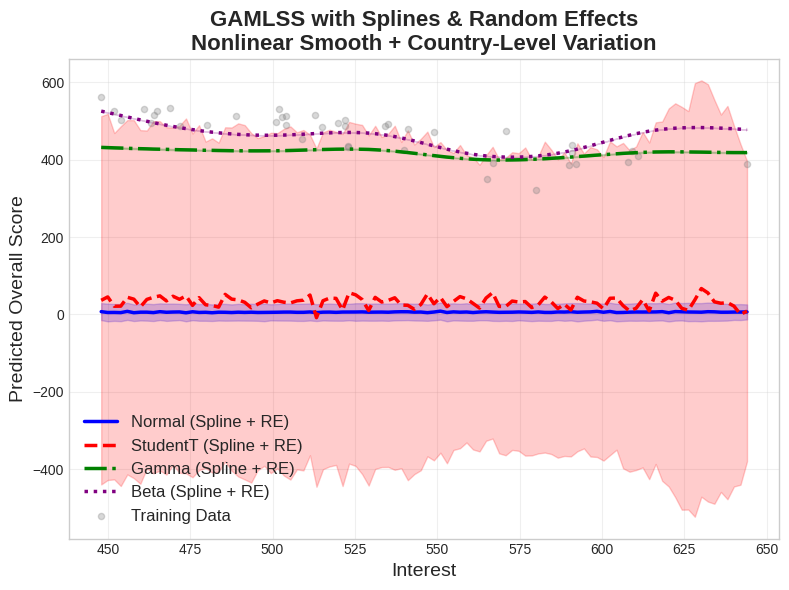

In [46]:
plt.figure(figsize=(8, 6))

colors = ['blue', 'red', 'green', 'purple']
linestyles = ['-', '--', '-.', ':']
models = ['Normal', 'StudentT', 'Gamma', 'Beta']

for i, model_name in enumerate(models):
    mu, std = predictions_enhanced[model_name]
    plt.plot(interest_grid, mu, 
             label=f'{model_name} (Spline + RE)', 
             color=colors[i], 
             linestyle=linestyles[i], 
             linewidth=2.5)
    plt.fill_between(interest_grid, mu - std, mu + std, 
                     color=colors[i], alpha=0.2)

# Add training data scatter
plt.scatter(train['Interest'], train['Overall'], 
           alpha=0.3, color='gray', s=20, label='Training Data')

plt.xlabel('Interest', fontsize=14)
plt.ylabel('Predicted Overall Score', fontsize=14)
plt.title('GAMLSS with Splines & Random Effects\nNonlinear Smooth + Country-Level Variation', fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Plot Training Losses

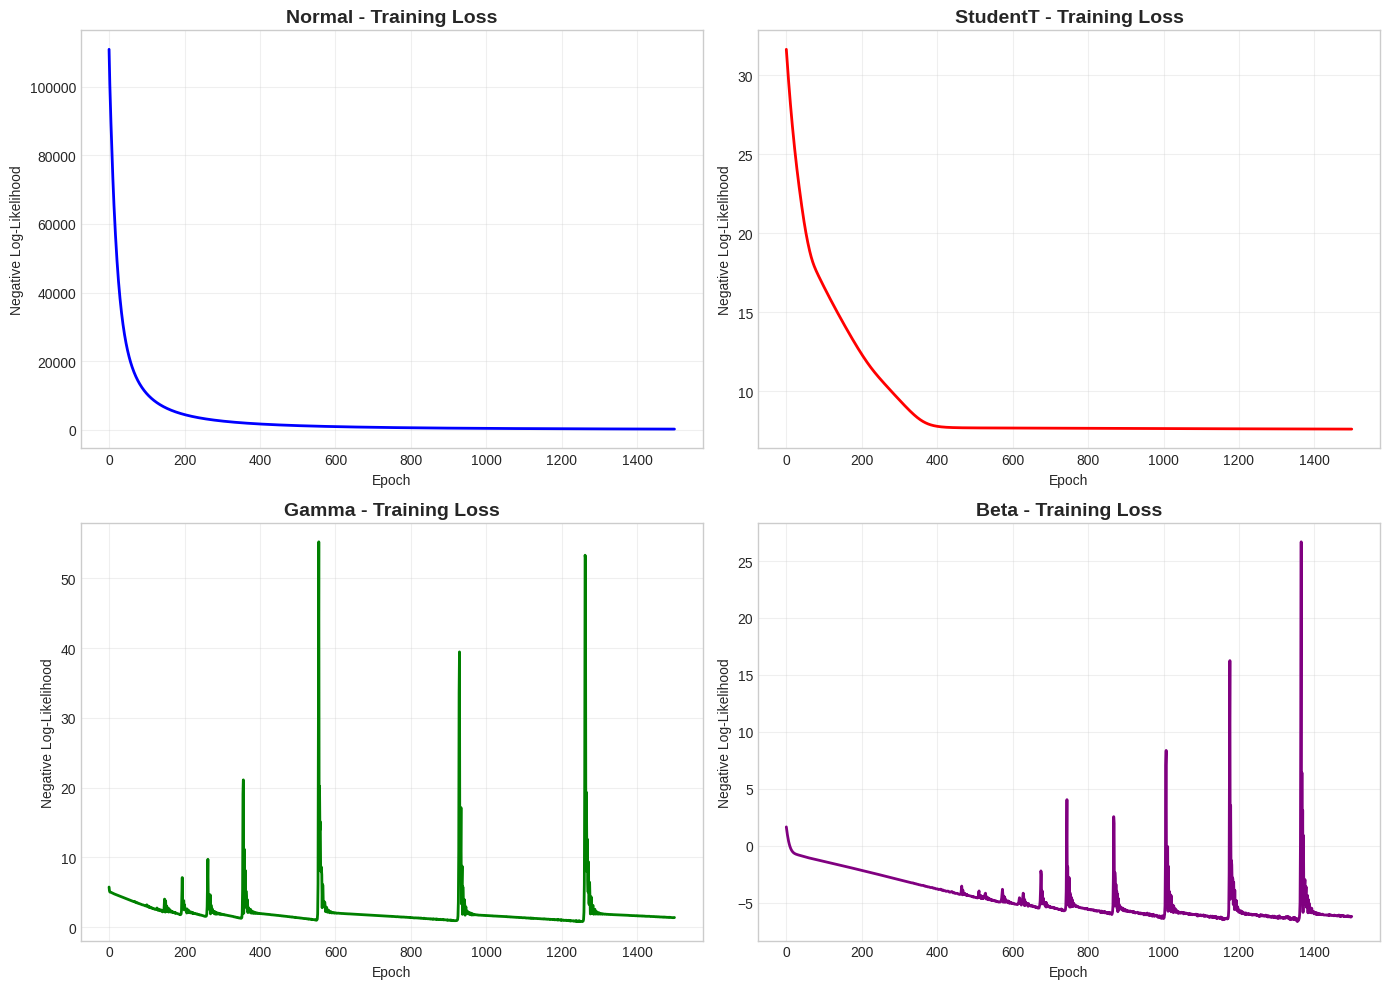

In [47]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, model_name in enumerate(models):
    axes[i].plot(losses_enhanced[model_name], color=colors[i], linewidth=2)
    axes[i].set_title(f'{model_name} - Training Loss', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Negative Log-Likelihood')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Visualize Random Effects (Country Intercepts)

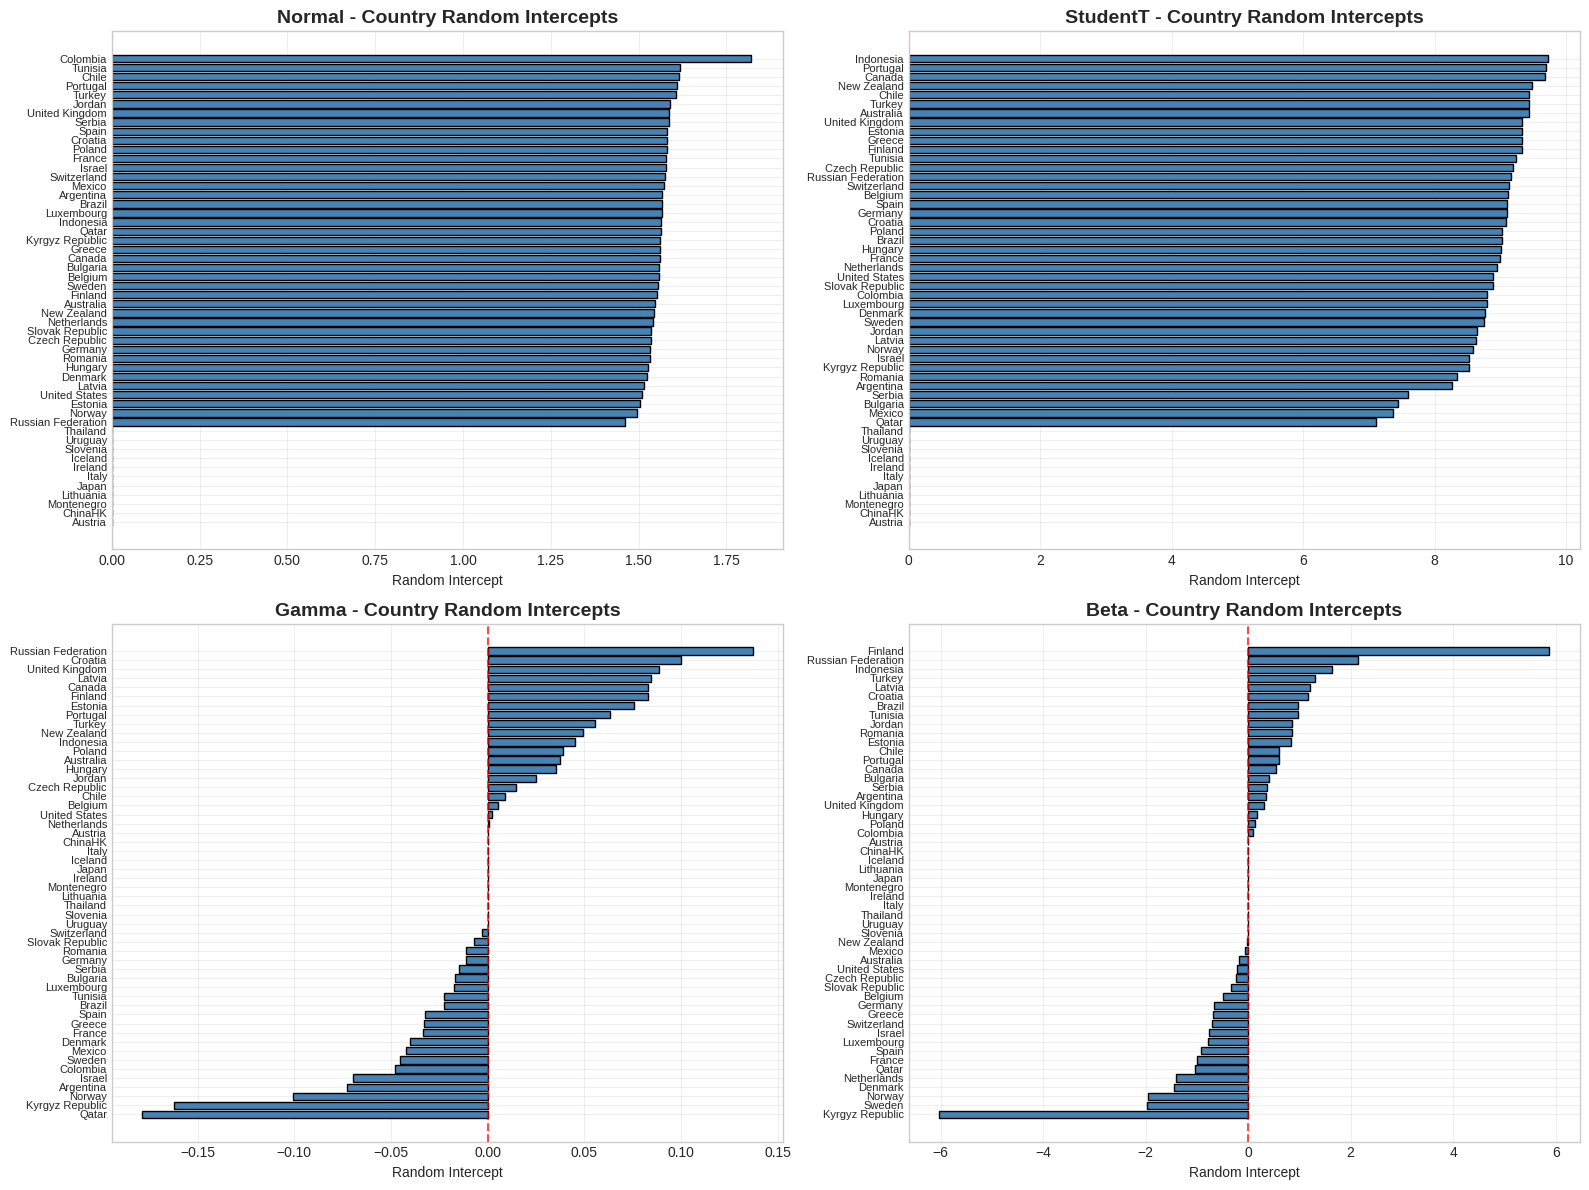

In [48]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, model_name in enumerate(models):
    model = models_enhanced[model_name]
    re_weights = model.country_re.weight.detach().squeeze().numpy()
    country_names = country_encoder.classes_
    
    # Sort by random effect magnitude
    sorted_idx = np.argsort(re_weights)
    sorted_re = re_weights[sorted_idx]
    sorted_countries = country_names[sorted_idx]
    
    axes[i].barh(range(len(sorted_re)), sorted_re, color='steelblue', edgecolor='black')
    axes[i].set_yticks(range(len(sorted_re)))
    axes[i].set_yticklabels(sorted_countries, fontsize=8)
    axes[i].set_title(f'{model_name} - Country Random Intercepts', fontsize=14, fontweight='bold')
    axes[i].axvline(0, color='red', linestyle='--', alpha=0.7)
    axes[i].set_xlabel('Random Intercept')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary & Conclusion


In this comprehensive tutorial, you learned how to build **Generalized Additive Models for Location, Scale, and Shape (GAMLSS)** from scratch in **PyTorch**, extending them with:

🔹 **Smoothing splines** — to model nonlinear relationships (e.g., the effect of student *Interest* on science scores) without assuming linearity.  
🔹 **Random intercepts** — to account for group-level variation (e.g., country-specific baseline performance).  
🔹 **Multiple response distributions** — including Normal, Student-t, Gamma, and Beta — each with appropriate link functions to handle different data types (symmetric, heavy-tailed, positive-skewed, bounded).  
🔹 **Stable training** — using proper parameter initialization and gradient clipping to avoid numerical instability.  
🔹 **Full uncertainty quantification** — generating predictive distributions and credible intervals via Monte Carlo sampling.  
🔹 **Model evaluation & comparison** — using test log-likelihood, AIC, and BIC to objectively select the best-fitting model.

You applied these techniques to real-world **PISA 2006 education data**, modeling student science performance as a function of socioeconomic and attitudinal predictors. The enhanced models revealed:

- Nonlinear patterns in how “Interest” affects scores.
- Systematic country-level differences captured by random effects.
- That skewed or robust distributions (Gamma, Student-t) often fit education data better than the Normal.


Key takeaways of this tutorial: 

1. **Flexibility is Power**  
   GAMLSS lets you model not just the mean, but also scale and shape parameters — adapting to the true nature of your data.

2. **Splines Capture Complexity**  
   B-spline bases allow smooth, nonlinear fits without overfitting — ideal for exploratory modeling.

3. **Random Effects Handle Structure**  
   Country, school, or subject-level variation can be modeled explicitly — improving both fit and inference.

4. **PyTorch is Perfect for This**  
   With `torch.distributions` and automatic differentiation, you can build and train complex probabilistic models without external dependencies.

5. **Evaluation Matters**  
   Use multiple metrics (LL, AIC, BIC) — especially when comparing models of different complexity.


This tutorial bridges **classical statistical modeling** (GAMLSS, splines, mixed effects) with **modern deep learning tools** (PyTorch, automatic differentiation, GPU acceleration). You now possess a **powerful, flexible, and production-ready framework** for modeling complex, real-world data — whether in education, healthcare, finance, or social science.

You didn’t just follow a tutorial — you built a **statistical modeling engine** capable of handling:

- Continuous, skewed, bounded, or heavy-tailed responses  
- Linear and nonlinear predictors  
- Hierarchical or grouped data  
- Full probabilistic predictions with uncertainty



## References

* Wood, S. N. (2017). Generalized Additive Models: An Introduction with R.
* Gelman, A., & Hill, J. (2006). Data Analysis Using Regression and Multilevel/Hierarchical Models.
* PyTorch Documentation: https://pytorch.org/docs/stable/distributions.html
* Scikit-learn SplineTransformer: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.SplineTransformer.html